In [4]:
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import math
import pickle

In [41]:
MU = 3.986*10**5#地球重力定数[km^3/s^2]
R_po = 6600.#パーキング軌道半径[km]
Delta_i = 30.#種子島の緯度[deg]
PI = np.pi
J2 = 1082.628*10**(-6)#J2帯状調和関数係数
R_e = 6

G = 9.81 #重力加速度[m/s^2]
R_earth = 6378 #地球の半径[km]
SCALE_HEIGHT = 8.432#スケールハイト[km]
RHO_0 = 1.225#標準大気密度[kg/m^3]
H_reEntry = 120 #大気圏高度[km]
M_earth = 5.9724*10**24

#機体によるので、あとで
A = np.pi #ハヤブサよりちょい大きめ[kg]
Rn = 2 #てきとー

#なんかを参照
Cd = 1.6
Cl = 0.0
DT = 0.1#刻み

In [42]:
def dominant_eq(D,L,gamma,v,r, M):
    gamma_rad = np.deg2rad(gamma)
    dot_r = v*np.sin(gamma_rad)
    dot_v = -D/M*10**3-g*np.sin(gamma_rad)*10**(-3)
    dotgamma_rad = L/(M*v)*10**3-g*np.cos(gamma_rad)/v*10**(-3)+v*np.cos(gamma_rad)/r
    dot_gamma = np.rad2deg(dotgamma_rad)
    return dot_r,dot_v,dot_gamma

def get_density(h):
    return RHO_0*np.exp(-h/SCALE_HEIGHT)

def get_precise_density(z):
    matrix = np.array([[0.000000,-3.322622E-6,9.111460E-4,-0.2609971,5.944694],
                       [0.000000,2.873405E-5,-0.008492037,0.6541179,-23.62010],
                       [-1.240774E-5,0.005162063,-0.8048342,55.55996,-1443.338],
                       [0.00000,-8.854164E-05,0.03373254,-4.390837,176.5294],
                       [3.661771E-7,-2.154344E-4,0.04809214,-4.884744,172.3597],
                       [1.906032E-8,-1.527799E-5,0.004724294,-0.6992340,20.50921],
                       [1.199282E-9,-1.451051E-6,6.910474E-4,-0.1736220,-5.321644],
                       [1.140564E-10,-2.130756E-7,1.570762E-4,-0.07029296,-12.89844],
                       [8.105631E-12,-2.358417E-9,-2.635110E-6,-0.01562608,-20.02246],                    
                       [-3.701195E-12,-8.608611E-9,5.118829E-5,-0.06600998,-6.137674]])
    Zs = np.array([z**4,z**3,z**2,z**1,1])
    if z>750:
        i = 9
        rho = np.exp(Zs@matrix[i])
    elif z>500:
        i = 8
        rho = np.exp(Zs@matrix[i])    
    elif z>300:
        i = 7
        rho = np.exp(Zs@matrix[i])    
    elif z>200:
        i = 6
        rho = np.exp(Zs@matrix[i])   
    elif z>150:
        i = 5
        rho = np.exp(Zs@matrix[i])    
    elif z>120:
        i = 4
        rho = np.exp(Zs@matrix[i])        
    elif z>110:
        i = 3
        rho = np.exp(Zs@matrix[i])    
    elif z>100:
        i = 2
        rho = np.exp(Zs@matrix[i])        
    elif z>91:
        i = 1
        rho = np.exp(Zs@matrix[i])        
    elif z>86:
        i = 0
        rho = np.exp(Zs@matrix[i])
    else:
        rho = RHO_0*np.exp(-z/SCALE_HEIGHT)
    
    return rho

def get_Drag_Lift(v,rho, S=A):
    D = 1/2*rho*v**2*S*Cd
    L = 1/2*rho*v**2*S*Cl
    return D,L

def f(h, v, gamma, M):
    rho = get_precise_density(h)
    D,  L = get_Drag_Lift(v, rho)
    r = h + R_earth
    dot_r, dot_v, dot_gamma = dominant_eq(D, L, gamma, v, r, M)
    return np.array([dot_r, dot_v, dot_gamma])

def get_heating_rate(density, v, Rn=Rn):
    """対流加熱と輻射過熱を考える
    Arg:
    density[kg/m^3] 大気密度
    v[km/s] 物体の速度
    Rn[m] ノーズ半径
    
    Return:
    q_conv[MW/m^2] 対流加熱率
    q_rad[MW/m^2] 輻射加熱率
    """
    v *= 10**3
    q_conv = 1.35*10**(-8)*np.sqrt(density/Rn)*v**3.04*10 #[kW/m^2]
    q_conv *= 10**(-3) #[MW/m^2]
    
    if Rn <= 1:
        a = 1.072*10**6*v**(-1.88)*density**(-0.325)
    elif 1< Rn <=2:
        a = min([0.6, 1.072*10**6*v**(-1.88)*density**(-0.325)])
    else:
        a = min([0.5, 1.072*10**6*v**(-1.88)*density**(-0.325)])
    
    f_v = 0
    V_lst = [9., 9.25, 9.5, 9.75, 10., 10.25, 10.5, 10.75, 11., 11.5]
    f_lst = [1.5, 4.3, 9.7, 19.5, 35, 55, 81, 115, 151, 238, 359]
    
    i = 0
    while v > V_lst[i]:
        i += 1
    
        
    q_rad = 4.736*10**2*Rn**a*density**1.22*f_v
    return q_conv, q_rad
    
def re_entry(v_reEntry,gamma_reEntry, M):
    h = H_reEntry
    v = v_reEntry
    gamma = gamma_reEntry
    rho = get_precise_density(h)
    q_conv, q_rad = get_heating_rate(rho, v)
    t = 0
    t_lst = [t]
    h_lst = [h]
    v_lst = [v]
    gamma_lst= [gamma]
    q_conv_lst, q_rad_lst = [q_conv], [q_rad]
    while 0 <= h <= H_reEntry:
        k1_vector = f(h, v, gamma,M)*DT
        k1_r, k1_v, k1_gamma = k1_vector[0], k1_vector[1], k1_vector[2]
        k1_h = k1_r
        
        k2_vector = f(h+k1_h/2, v+k1_v/2, gamma+k1_gamma/2, M)*DT
        k2_r, k2_v, k2_gamma = k2_vector[0], k2_vector[1], k2_vector[2]
        k2_h = k2_r

        k3_vector = f(h+k2_h/2, v+k2_v/2, gamma+k2_gamma/2, M)*DT
        k3_r, k3_v, k3_gamma = k3_vector[0], k3_vector[1], k3_vector[2]
        k3_h = k3_r

        k4_vector = f(h+k3_h, v+k3_v, gamma+k3_gamma, M)*DT
        k4_r, k4_v, k4_gamma = k4_vector[0], k4_vector[1], k4_vector[2]
        k4_h = k4_r

        delta_r_euqual_h = (k1_r + 2.*k2_r + 2.*k3_r + k4_r)/6.
        delta_v = (k1_v + 2.*k2_v + 2.*k3_v + k4_v)/6.
        delta_gamma = (k1_gamma + 2.*k2_gamma + 2.*k3_gamma + k4_gamma)/6
        ####################################
        h += delta_r_euqual_h
        v += delta_v
        gamma += delta_gamma
        t += DT
        heating_rate = get_heating_rate(get_precise_density(h), v)
        t_lst.append(t)
        h_lst.append(h)
        v_lst.append(v)
        gamma_lst.append(gamma)
        q_conv_lst.append(heating_rate[0])
        q_rad_lst.append(heating_rate[1])
    if h_lst[-1] >= H_reEntry:
        #大気に弾かれた場合
        print(h_lst[-1])

    else:
        #print("カプセル帰還")
        pass
    return t_lst, h_lst, v_lst, gamma_lst, q_conv_lst, q_rad_lst

In [73]:
class Satellite:
    def __init__(self, dry_mass, mass_capsule, first_dry_mass, orbital_height, is_capsule=True):
        """衛星のパラメータと軌道設計すれば、全部吐くやつ
        Arg:
            dry_mass[kg] 衛星全部のdry質量
            mass_capsule[kg] カプセルの重量(=dry_mass-2段目の構造重量)
            first_dry_mass[kg] 1段目のドライ重量[kg]
            orbital_height[km] 軌道半径(円軌道)
        Attribute:
        """
        self.dry_mass = dry_mass #dry重量(カプセル含む)
        self.mass_capsule = mass_capsule #カプセル重量(dry重量 - 箱)
        self.first_dry_mass = first_dry_mass
        self.orbital_hegiht = orbital_height #周回軌道高度@phase2
        self.semi_major_axis = orbital_height+R_earth #周回軌道半径@phase2
        self.v_tgt_apo = np.sqrt(MU/self.semi_major_axis) #周回速度@phase2
        self.mass_ab = None
        
    def get_prop_phase1(self, prop_phase3, height_leo=250., Isp=329.):
        """phase1での燃料推算
        Arg:
            prop_phase3[kg] phase3での燃料質量
            hegiht_leo[km] LEO軌道の高度(ここまでは相乗り前提) default:250
            Isp[s] 比推力 default:329(BT-4)
        Return:
            prop_phase1[kg] phase1での必要燃料
        """
        mass_f = self.dry_mass + prop_phase3 
        r_leo = height_leo + R_earth
        v_trans_apo = np.sqrt(2.*MU*(1./self.semi_major_axis - 1./(self.semi_major_axis+r_leo)))
        delta_v = self.v_tgt_apo - v_trans_apo
        mass_prop = mass_f*(np.exp(delta_v*10**3/G/Isp)-1)
        return mass_prop
    
    def decision_v_return_apo(self, atmosphere_height=120.):
        """大気に入るためのアポジの最大速度推算
            要するにこれより小さければ戻ってこれる
        Arg:
            atmosphere_height[km] 大気高度 default 120
        Return:
            max_v_apo[km/s] 最大速度
        """
        r_p = atmosphere_height + R_earth
        max_v_apo = np.sqrt(2*MU*(1./self.semi_major_axis-1./(self.semi_major_axis+r_p)))
        return max_v_apo
    
    def get_prop_phase3(self, v_trans_apo, Isp=329., atmosphere_height=120.):
        """phase3での燃料推算
        Arg:
            v_trans_apo[km/s] phase3でのアポジの速度
            Isp[s] 燃料の比推力 default:329
            atmosphere_height[km] 大気の高度 default:120.
        """
        assert self.decision_v_return_apo(atmosphere_height=atmosphere_height) > v_trans_apo,\
            "帰らない"
        delta_v = self.v_tgt_apo - v_trans_apo
        mass_prop = (self.dry_mass-self.first_dry_mass)*(np.exp(delta_v*10**3/G/Isp)-1)
        return mass_prop
    
    def get_tank_parameter(self, mass_prop, density_prop, number, rate=0.1):
        """タンク設計
        Arg:
            mass_prop[kg] 燃料(酸化剤)重量
            density_prop[kg/m^3] 燃料(酸化剤)の密度
            number[] タンク個数
            rate 推進剤重量に対するタンク重量の割合 default:0.1
            
        Return:
            mass_tank[kg] タンク重量
            d_tank[mm] タンクが球形と仮定したときのタンクの直径
        """
        mass_tank = rate*mass_prop
        volume_tank = mass_prop/density_prop/2
        r_tank = (3*volume_tank/4/PI)**(1/3) #[m]
        d_tank = np.ceil(2*r_tank*10**3) #[mm]
        return mass_tank, d_tank
        
        
    def re_entry_simu(self, v_trans_apo, atmosphere_height=120., plot=False):
        """熱荷重を求める
        Arg:
            v_trans_apo[km/s] 帰還時のアポジの速度
            atmosphere_height[km] 大気高度 default:200
            plot(bool) プロットするかどうか default:False
        Return:
            heat_load[MJ/m^2] 総熱荷重
        """
        assert self.decision_v_return_apo(atmosphere_height=atmosphere_height) > v_trans_apo,\
            "帰らない"
        r_e = atmosphere_height + R_earth
        v_entry = np.sqrt(v_trans_apo**2 + 2*MU*(1/r_e-1/self.semi_major_axis))
        fpa_entry = np.rad2deg(-np.arccos(v_trans_apo*self.semi_major_axis/v_entry/r_e))
        print(v_entry)
        print(fpa_entry)
        t_lst, h_lst, v_lst, gamma_lst, q_conv_lst, q_rad_lst \
            = re_entry(v_entry, fpa_entry, M=self.mass_capsule)
        heat_load = 0
        for i in range(len(t_lst)-1):
            heat_flux = q_conv_lst[i] + q_rad_lst[i]
            heat_load += heat_flux*DT
        
        if plot is True:
            plt.plot(v_lst, h_lst)
            plt.show()
            plt.plot(t_lst, q_conv_lst)
            plt.show()
            plt.plot(t_lst, q_rad_lst)
            plt.show()
            
            
        return heat_load
    
    def get_ablator_mass(self, heat_load):
        """アブレーターの重さをもとメルル
        Arg:
            heat_load[MJ/m^2] 総熱荷重
        Return:
            mass_ablator[kg]
        """
        heat_load = heat_load*10**2 #[J/cm^2]
        mass_fraction = 0.091*heat_load**0.51
        mass_fraction /= 100.
        mass_ablator = mass_fraction * self.mass_capsule
        self.mass_ab = mass_ablator
        return mass_ablator
    
    def get_ablator_thickness(self, mass_ablator, area_capsule, density_ablator=1000.):
        """アブレータの厚さを求める
        Arg:
            mass_ablator[kg] アブレータ質量
            area_capsure[m^2] アブレータの表面積=カプセルの前方
            density_ablator[kg/m^3] アブレータ default:1000（炭化アブレータ）
        
        Return:
            thickness_ablator[mm] アブレータの厚さ
        """
        thickness_ablator = mass_ablator/area_capsule/density_ablator#[m]
        thickness_ablator *= 1000 #[mm]
        return thickness_ablator

## 各面の質量
|配分|質量|
|:--:|:--:|
|コンポーネント重量|851kg|
|構造質量|208kg|
|電気配線|54kg|
|システムマージン|60kg|

|節点|構造重量[kg]|
|:--:|:--:|
|1|5.47|
|2|45.5|
|3|23.3|
|4|55.9|
|5|23.3|
|6|67.6|
|7|23.3|

よって、SM+2段目と1段目の構造重量は

|モジュール|構造重量[kg]|
|:--:|:--:|
|SM+2段目|153.47|
|1段目|90.9|

コンポーネントは、1段目のタンク重量100kgとすると

|モジュール|コンポ重量|
|:--:|:--:|
|SM+2段目|751|
|1段目|100|

電気配線とシステムマージンは（とりあえず）SM+1段目とすると,

それぞれのドライ重量は

|モジュール|ドライ重量[kg]|
|:--:|:--:|
|SM+2段目|1372.47|
|1段目|190.9|
|衛星全部|1563.37|

SM重量は2段目のタンク重量とかがわからないとわからないので、
とりあえず、1000kgとかにする

In [74]:
e_osiris = Satellite(dry_mass=846.57, mass_capsule=900, first_dry_mass=190.9,
                    orbital_height=25000)

delta_v = 1.56
v_trans_apo = e_osiris.v_tgt_apo - delta_v

In [75]:
prop_phase3 = e_osiris.get_prop_phase3(v_trans_apo)
print(prop_phase3)

852.9814124784832


In [76]:
prop_phase1 = e_osiris.get_prop_phase1(prop_phase3)
print(prop_phase1)

1381.3017463041533


In [77]:
min_delta_v = e_osiris.v_tgt_apo-e_osiris.decision_v_return_apo()
print(min_delta_v)

1.4763988128449084


10.064501268110595
-15.934545665156431


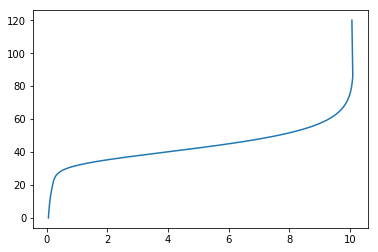

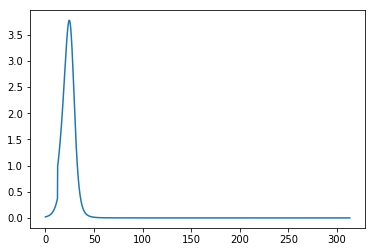

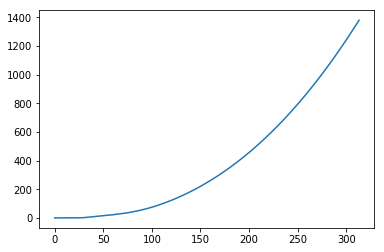

3397.886377067073


In [78]:
heat_load = e_osiris.re_entry_simu(v_trans_apo, plot=True)
ablator_mass = e_osiris.get_ablator_mass(heat_load)
print(ablator_mass)